## Pipeline for microendoscopic data processing in CaImAn using the CNMF-E algorithm
This demo presents a complete pipeline for processing microendoscopic data using CaImAn. It includes:
- Motion Correction using the NoRMCorre algorithm
- Source extraction using the CNMF-E algorithm
- Deconvolution using the OASIS algorithm

Some basic visualization is also included. The demo illustrates how to `params`, `MoctionCorrection` and `cnmf` object for processing 1p microendoscopic data. For processing two-photon data consult the related `demo_pipeline.ipynb` demo. For more information see the companion CaImAn paper.

In [1]:
try:
    get_ipython().run_line_magic('load_ext' , 'autoreload')
    get_ipython().run_line_magic('autoreload', 2)
except:
    pass

import logging
import matplotlib.pyplot as plt
import numpy as np

logging.basicConfig(format=
                          "%(relativeCreated)12d [%(filename)s:%(funcName)20s():%(lineno)s] [%(process)d] %(message)s",
                    # filename="/tmp/caiman.log",
                    level=logging.WARNING)

import caiman as cm
from caiman.source_extraction import cnmf
from caiman.utils.utils import download_demo
from caiman.utils.visualization import inspect_correlation_pnr, nb_inspect_correlation_pnr
from caiman.motion_correction import MotionCorrect
from caiman.source_extraction.cnmf import params as params
from caiman.utils.visualization import plot_contours, nb_view_patches, nb_plot_contour
import cv2

try:
    cv2.setNumThreads(0)
except:
    pass
import bokeh.plotting as bpl
import holoviews as hv
bpl.output_notebook()

try:
    hv.notebook_extension('bokeh')
except:
    print("fail")

Loading BokehJS ...

       17158 [parameterized.py:          __db_print():2533] [31155] Holoviews bokeh extension could not be imported, it raised the following exception: ValueError('ClassSelector parameter None value must be an instance of (function, tuple), not <function size at 0x1062d48b0>.')


fail


### Select file(s) to be processed
The `download_demo` function will download the specific file for you and return the complete path to the file which will be stored in your `caiman_data` directory. If you adapt this demo for your data make sure to pass the complete path to your file(s). Remember to pass the `fnames` variable as a list. Note that the memory requirement of the CNMF-E algorithm are much higher compared to the standard CNMF algorithm. Test the limits of your system before trying to process very large amounts of data.

In [3]:
fnames = ['data_endoscope.tif']  # filename to be processed
fnames = [download_demo(fnames[0])]

### Setup a cluster
To enable parallel processing a (local) cluster needs to be set up. This is done with a cell below. The variable `backend` determines the type of cluster used. The default value `'local'` uses the multiprocessing package. The `ipyparallel` option is also available. More information on these choices can be found [here](https://github.com/flatironinstitute/CaImAn/blob/master/CLUSTER.md). The resulting variable `dview` expresses the cluster option. If you use `dview=dview` in the downstream analysis then parallel processing will be used. If you use `dview=None` then no parallel processing will be employed.

In [4]:
#%% start a cluster for parallel processing (if a cluster already exists it will be closed and a new session will be opened)
if 'dview' in locals():
    cm.stop_server(dview=dview)
c, dview, n_processes = cm.cluster.setup_cluster(
    backend='local', n_processes=None, single_thread=False)

### Setup some parameters
We first set some parameters related to the data and motion correction and create a `params` object. We'll modify this object with additional settings later on. You can also set all the parameters at once as demonstrated in the `demo_pipeline.ipynb` notebook.

In [18]:
# dataset dependent parameters
frate = 10                       # movie frame rate
decay_time = 0.4                 # length of a typical transient in seconds

# motion correction parameters
motion_correct = True    # flag for performing motion correction
pw_rigid = False         # flag for performing piecewise-rigid motion correction (otherwise just rigid)
gSig_filt = (3, 3)       # size of high pass spatial filtering, used in 1p data
max_shifts = (1, 1)      # maximum allowed rigid shift
strides = (48, 48)       # start a new patch for pw-rigid motion correction every x pixels
overlaps = (24, 24)      # overlap between pathes (size of patch strides+overlaps)
max_deviation_rigid = 3  # maximum deviation allowed for patch with respect to rigid shifts
border_nan = 'copy'      # replicate values along the boundaries

mc_dict = {
    'fnames': fnames,
    'fr': frate,
    'decay_time': decay_time,
    'pw_rigid': pw_rigid,
    'max_shifts': max_shifts,
    'gSig_filt': gSig_filt,
    'strides': strides,
    'overlaps': overlaps,
    'max_deviation_rigid': max_deviation_rigid,
    'border_nan': border_nan
}

opts = params.CNMFParams(params_dict=mc_dict)

### Motion Correction
The background signal in micro-endoscopic data is very strong and makes the motion correction challenging. 
As a first step the algorithm performs a high pass spatial filtering with a Gaussian kernel to remove the bulk of the background and enhance spatial landmarks. 
The size of the kernel is given from the parameter `gSig_filt`. If this is left to the default value of `None` then no spatial filtering is performed (default option, used in 2p data).
After spatial filtering, the NoRMCorre algorithm is used to determine the motion in each frame. The inferred motion is then applied to the *original* data so no information is lost.

The motion corrected files are saved in memory mapped format. If no motion correction is being performed, then the file gets directly memory mapped.

      485302 [movies.py:      extract_shifts():339] [28793] Movie average is negative. Removing 1st percentile.
      485303 [movies.py:      extract_shifts():357] [28793] Movie average is negative. Removing 1st percentile.
      485334 [movies.py:      extract_shifts():339] [28793] Movie average is negative. Removing 1st percentile.
      485335 [movies.py:      extract_shifts():357] [28793] Movie average is negative. Removing 1st percentile.
      485366 [movies.py:      extract_shifts():339] [28793] Movie average is negative. Removing 1st percentile.
      485367 [movies.py:      extract_shifts():357] [28793] Movie average is negative. Removing 1st percentile.


Decode mmap filename /Users/js0403/caiman_data/example_movies/data_endoscope_rig__d1_128_d2_128_d3_1_order_F_frames_1000.mmap


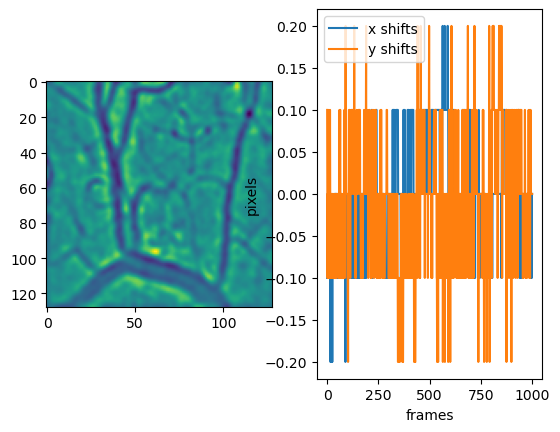

In [19]:
if motion_correct:
    # do motion correction rigid
    mc = MotionCorrect(fnames, dview=dview, **opts.get_group('motion'))
    mc.motion_correct(save_movie=True)
    fname_mc = mc.fname_tot_els if pw_rigid else mc.fname_tot_rig
    if pw_rigid:
        bord_px = np.ceil(np.maximum(np.max(np.abs(mc.x_shifts_els)),
                                     np.max(np.abs(mc.y_shifts_els)))).astype(int)
    else:
        bord_px = np.ceil(np.max(np.abs(mc.shifts_rig))).astype(int)
        plt.subplot(1, 2, 1); plt.imshow(mc.total_template_rig)  # % plot template
        plt.subplot(1, 2, 2); plt.plot(mc.shifts_rig)  # % plot rigid shifts
        plt.legend(['x shifts', 'y shifts'])
        plt.xlabel('frames')
        plt.ylabel('pixels')

    bord_px = 0 if border_nan == 'copy' else bord_px
    fname_new = cm.save_memmap(fname_mc, base_name='memmap_', order='C',
                               border_to_0=bord_px)
else:  # if no motion correction just memory map the file
    fname_new = cm.save_memmap(fnames, base_name='memmap_',
                               order='C', border_to_0=0, dview=dview)

### Load memory mapped file

In [20]:
# load memory mappable file
Yr, dims, T = cm.load_memmap(fname_new)
images = Yr.T.reshape((T,) + dims, order='F')

Decode mmap filename /Users/js0403/caiman_data/example_movies/memmap_d1_128_d2_128_d3_1_order_C_frames_1000.mmap


### Parameter setting for CNMF-E
We now define some parameters for the source extraction step using the CNMF-E algorithm. 
We construct a new dictionary and use this to modify the *existing* `params` object,

In [28]:
# parameters for source extraction and deconvolution
p = 1               # order of the autoregressive system

# This sets the number of ROIs per patch, keep to None
K = None            # upper bound on number of components per patch, in general None

# changing gSig changes the diameter of the ROI
gSig = (3, 3)       # gaussian width of a 2D gaussian kernel, which approximates a neuron
gSiz = (4*gSig[0]+1, 4*gSig[1]+1)     # average diameter of a neuron, in general 4*gSig+1

Ain = None          # possibility to seed with predetermined binary masks
merge_thr = .7      # merging threshold, max correlation allowed
rf = 40             # half-size of the patches in pixels. e.g., if rf=40, patches are 80x80
stride_cnmf = 20    # amount of overlap between the patches in pixels
#                     (keep it at least large as gSiz, i.e 4 times the neuron size gSig)
tsub = 2            # downsampling factor in time for initialization,
#                     increase if you have memory problems
ssub = 1            # downsampling factor in space for initialization,
#                     increase if you have memory problems
#                     you can pass them here as boolean vectors
low_rank_background = None  # None leaves background of each patch intact,
#                     True performs global low-rank approximation if gnb>0
gnb = 0             # number of background components (rank) if positive,
#                     else exact ring model with following settings
#                         gnb= 0: Return background as b and W
#                         gnb=-1: Return full rank background B
#                         gnb<-1: Don't return background
nb_patch = 0        # number of background components (rank) per patch if gnb>0,
#                     else it is set automatically
min_corr = .8       # min peak value from correlation image
min_pnr = 10        # min peak to noise ration from PNR image
ssub_B = 2          # additional downsampling factor in space for background
ring_size_factor = 1.4  # radius of ring is gSiz*ring_size_factor

opts.change_params(params_dict={'method_init': 'corr_pnr',  # use this for 1 photon
                                'K': K,
                                'gSig': gSig,
                                'gSiz': gSiz,
                                'merge_thr': merge_thr,
                                'p': p,
                                'tsub': tsub,
                                'ssub': ssub,
                                'rf': rf,
                                'stride': stride_cnmf,
                                'only_init': True,    # set it to True to run CNMF-E
                                'nb': gnb,
                                'nb_patch': nb_patch,
                                'method_deconvolution': 'oasis',       # could use 'cvxpy' alternatively
                                'low_rank_background': low_rank_background,
                                'update_background_components': True,  # sometimes setting to False improve the results
                                'min_corr': min_corr,
                                'min_pnr': min_pnr,
                                'normalize_init': False,               # just leave as is
                                'center_psf': True,                    # leave as is for 1 photon
                                'ssub_B': ssub_B,
                                'ring_size_factor': ring_size_factor,
                                'del_duplicates': True,                # whether to remove duplicates from initialization
                                'border_pix': bord_px})                # number of pixels to not consider in the borders)

CNMFParams:

data:

{'caiman_version': '1.9.15',
 'decay_time': 0.4,
 'dims': (128, 128),
 'dxy': (1, 1),
 'fnames': ['/Users/js0403/caiman_data/example_movies/data_endoscope.tif'],
 'fr': 10,
 'last_commit': 'GITW-a8ddd5fd20850eb9e070113b09066a4065df4a45',
 'mmap_C': None,
 'mmap_F': None,
 'var_name_hdf5': 'mov'}

spatial_params:

{'block_size_spat': 5000,
 'dist': 3,
 'expandCore': array([[0, 0, 1, 0, 0],
       [0, 1, 1, 1, 0],
       [1, 1, 1, 1, 1],
       [0, 1, 1, 1, 0],
       [0, 0, 1, 0, 0]]),
 'extract_cc': True,
 'maxthr': 0.1,
 'medw': None,
 'method_exp': 'dilate',
 'method_ls': 'lasso_lars',
 'n_pixels_per_process': 1489,
 'nb': 0,
 'normalize_yyt_one': True,
 'nrgthr': 0.9999,
 'num_blocks_per_run_spat': 20,
 'se': None,
 'ss': None,
 'thr_method': 'nrg',
 'update_background_components': True}

temporal_params:

{'ITER': 2,
 'bas_nonneg': False,
 'block_size_temp': 5000,
 'fudge_factor': 0.96,
 'lags': 5,
 'memory_efficient': False,
 'method_deconvolution': 'oasis',
 '

### Inspect summary images and set parameters
Check the optimal values of `min_corr` and `min_pnr` by moving slider in the figure that pops up. You can modify them in the `params` object. 
Note that computing the correlation pnr image can be computationally and memory demanding for large datasets. In this case you can compute
only on a subset of the data (the results will not change). You can do that by changing `images[::1]` to `images[::5]` or something similar.
This will compute the correlation pnr image

In [29]:
# compute some summary images (correlation and peak to noise)
cn_filter, pnr = cm.summary_images.correlation_pnr(images[::1], gSig=gSig[0], swap_dim=False) # change swap dim if output looks weird, it is a problem with tiffile
# inspect the summary images and set the parameters
nb_inspect_correlation_pnr(cn_filter, pnr) # If Bokeh isn't working, this wont work

:Layout
   .AdjointLayout.Correlation :AdjointLayout
      :Image   [x,y]   (corr)
      :DynamicMap   []
   .AdjointLayout.Pnr         :AdjointLayout
      :Image   [x,y]   (pnr)
      :DynamicMap   []

You can inspect the correlation and PNR images to select the threshold values for `min_corr` and `min_pnr`. The algorithm will look for components only in places where these value are above the specified thresholds. You can adjust the dynamic range in the plots shown above by choosing the selection tool (third button from the left) and selecting the desired region in the histogram plots on the right of each panel.

In [30]:
# print parameters set above, modify them if necessary based on summary images
print(min_corr) # min correlation of peak (from correlation image)
print(min_pnr)  # min peak to noise ratio

0.8
10


### Run the CNMF-E algorithm

In [31]:
cnm = cnmf.CNMF(n_processes=n_processes, dview=dview, Ain=Ain, params=opts)
cnm.fit(images)

Decode mmap filename /Users/js0403/caiman_data/example_movies/memmap_d1_128_d2_128_d3_1_order_C_frames_1000.mmap
Decode mmap filename /Users/js0403/caiman_data/example_movies/memmap_d1_128_d2_128_d3_1_order_C_frames_1000.mmap
Decode mmap filename /Users/js0403/caiman_data/example_movies/memmap_d1_128_d2_128_d3_1_order_C_frames_1000.mmap
Decode mmap filename /Users/js0403/caiman_data/example_movies/memmap_d1_128_d2_128_d3_1_order_C_frames_1000.mmap


/Users/js0403/anaconda3/envs/caiman/lib/python3.10/site-packages/scipy/sparse/_dia.py:339: RuntimeWarning: divide by zero encountered in remainder
  c = np.arange(num_rows, dtype=np.intc) - (offsets % max_dim)[:, None]
/Users/js0403/anaconda3/envs/caiman/lib/python3.10/site-packages/scipy/sparse/_dia.py:339: RuntimeWarning: divide by zero encountered in remainder
  c = np.arange(num_rows, dtype=np.intc) - (offsets % max_dim)[:, None]
/Users/js0403/anaconda3/envs/caiman/lib/python3.10/site-packages/scipy/sparse/_dia.py:339: RuntimeWarning: divide by zero encountered in remainder
  c = np.arange(num_rows, dtype=np.intc) - (offsets % max_dim)[:, None]
/Users/js0403/anaconda3/envs/caiman/lib/python3.10/site-packages/scipy/sparse/_dia.py:339: RuntimeWarning: divide by zero encountered in remainder
  c = np.arange(num_rows, dtype=np.intc) - (offsets % max_dim)[:, None]


### Alternate way to run the pipeline at once
It is possible to run the combined steps of motion correction, memory mapping, and cnmf fitting in one step as shown below. The command is commented out since the analysis has already been performed. It is recommended that you familiriaze yourself with the various steps and the results of the various steps before using it.

In [ ]:
# cnm1 = cnmf.CNMF(n_processes, params=opts, dview=dview)
# cnm1.fit_file(motion_correct=motion_correct)

## Component Evaluation

The processing in patches creates several spurious components. These are filtered out by evaluating each component using three different criteria:

- the shape of each component must be correlated with the data at the corresponding location within the FOV
- a minimum peak SNR is required over the length of a transient
- each shape passes a CNN based classifier

<img src="../../docs/img/evaluationcomponent.png"/>
After setting some parameters we again modify the existing `params` object.

In [32]:
#%% COMPONENT EVALUATION
# the components are evaluated in two ways:
#   a) the shape of each component must be correlated with the data
#   b) a minimum peak SNR is required over the length of a transient
# Note that here we do not use the CNN based classifier, because it was trained on 2p not 1p data

min_SNR = 3            # adaptive way to set threshold on the transient size
r_values_min = 0.85    # threshold on space consistency (if you lower more components
#                        will be accepted, potentially with worst quality)
cnm.params.set('quality', {'min_SNR': min_SNR,
                           'rval_thr': r_values_min,
                           'use_cnn': False})
cnm.estimates.evaluate_components(images, cnm.params, dview=dview)

print(' ***** ')
print('Number of total components: ', len(cnm.estimates.C))
print('Number of accepted components: ', len(cnm.estimates.idx_components))

Decode mmap filename /Users/js0403/caiman_data/example_movies/memmap_d1_128_d2_128_d3_1_order_C_frames_1000.mmap
 ***** 
Number of total components:  14
Number of accepted components:  14


### Do some plotting

In [33]:
#%% plot contour plots of accepted and rejected components
cnm.estimates.plot_contours_nb(img=cn_filter, idx=cnm.estimates.idx_components)

View traces of accepted and rejected components. Note that if you get data rate error you can start Jupyter notebooks using:
'jupyter notebook --NotebookApp.iopub_data_rate_limit=1.0e10'

In [14]:
# accepted components
cnm.estimates.hv_view_components(img=cn_filter, idx=cnm.estimates.idx_components,
                                denoised_color='red', cmap='gray')

:DynamicMap   [unit_id,scale]

In [15]:
# rejected components - doesn't work
cnm.estimates.hv_view_components(img=cn_filter, idx=cnm.estimates.idx_components_bad,
                                denoised_color='red', cmap='gray')

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

### Stop cluster

In [ ]:
cm.stop_server(dview=dview)

### Some instructive movies
Play the reconstructed movie alongside the original movie and the (amplified) residual

In [16]:
# with background 
cnm.estimates.play_movie(images, q_max=99.5, magnification=2,
                                 include_bck=True, gain_res=10, bpx=bord_px)

movie([[[ 8.85951172e+02,  8.85951172e+02,  8.85564636e+02, ...,
          1.18884277e+01, -1.09478760e+01, -2.49511719e+00],
        [ 8.86053345e+02,  8.86053345e+02,  8.88075867e+02, ...,
          2.17797852e+01,  1.83978271e+01,  3.51153564e+01],
        [ 8.96982605e+02,  8.96982605e+02,  8.96767700e+02, ...,
          1.27362061e+01, -8.21960449e+00,  1.18939209e+01],
        ...,
        [ 7.61696594e+02,  7.61696594e+02,  7.68821350e+02, ...,
          2.17456055e+01, -7.93273926e+00, -2.25830078e+00],
        [ 7.58966614e+02,  7.58966614e+02,  7.63617981e+02, ...,
          2.73303223e+01,  2.33740234e+01, -6.61132812e+00],
        [ 7.58966614e+02,  7.58966614e+02,  7.63617981e+02, ...,
          4.64715576e+01,  2.79534912e+01, -1.54357910e+00]],

       [[ 8.84000122e+02,  8.84000122e+02,  8.84000122e+02, ...,
         -3.41418457e+01, -3.21240234e+01, -5.14208984e+01],
        [ 8.90000122e+02,  8.83000122e+02,  8.89000122e+02, ...,
          3.56500244e+01, -1.05566406e

In [17]:
# without background
cnm.estimates.play_movie(images, q_max=99.9, magnification=2,
                                 include_bck=False, gain_res=4, bpx=bord_px)

movie([[[-6.70349121e-01, -3.20922852e-01, -2.06903076e+00, ...,
          4.75537109e+00, -4.37915039e+00, -9.98046875e-01],
        [-3.41271973e+00, -1.89617920e+00, -2.30859375e+00, ...,
          8.71191406e+00,  7.35913086e+00,  1.40461426e+01],
        [ 1.81610107e+00,  2.17663574e+00,  1.44519043e+00, ...,
          5.09448242e+00, -3.28784180e+00,  4.75756836e+00],
        ...,
        [-7.92297363e-01, -2.94537354e+00, -2.44665527e+00, ...,
          8.69824219e+00, -3.17309570e+00, -9.03320312e-01],
        [ 2.51135254e+00, -2.37860107e+00, -3.13421631e+00, ...,
          1.09321289e+01,  9.34960938e+00, -2.64453125e+00],
        [ 4.71112061e+00,  1.91455078e+00,  3.13964844e+00, ...,
          1.85886230e+01,  1.11813965e+01, -6.17431641e-01]],

       [[ 2.82940674e+00,  3.17883301e+00,  1.44128418e+00, ...,
         -1.36567383e+01, -1.28496094e+01, -2.05683594e+01],
        [ 5.98486328e+00,  5.01403809e-01,  3.69049072e+00, ...,
          1.42600098e+01, -4.22265625e